In [ ]:
# supervised machinelearning


In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import logging
import numpy as np
import string
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn import svm
from datetime import datetime
import os
from gensim.models.word2vec import Word2Vec
import gensim
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from collections import defaultdict

In [4]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
path_to_models = '/Users/anne/repos/embedding_models/'

In [6]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 100

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 100

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
    
    
    

In [13]:
path_to_data ='../data/'
df = pd.read_pickle(path_to_data + "data_geannoteerd.pkl")
data = df['text']
labels = df['topic']

In [10]:
print("\nLoading aem_320d model")

mod = gensim.models.Word2Vec.load(path_to_models + 'w2v_320d')
aem_320d = dict(zip(mod.wv.index2word, mod.wv.syn0))

INFO:gensim.utils:loading Word2Vec object from /Users/anne/repos/embedding_models/w2v_320d



Loading aem_320d model


INFO:gensim.utils:loaded /Users/anne/repos/embedding_models/w2v_320d
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


In [11]:
print("\nLoading aem_300d model")

mod = gensim.models.Word2Vec.load(path_to_models + 'w2v_300d')
aem_300d = dict(zip(mod.wv.index2word, mod.wv.syn0))


INFO:gensim.utils:loading Word2Vec object from /Users/anne/repos/embedding_models/w2v_300d



Loading aem_300d model


INFO:gensim.utils:loaded /Users/anne/repos/embedding_models/w2v_300d
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


In [12]:
print("\nLoading wiki model")

model = gensim.models.KeyedVectors.load_word2vec_format(path_to_models + 'wiki.nl.vec')
wiki = dict(zip(model.wv.index2word, model.wv.syn0))


INFO:gensim.models.utils_any2vec:loading projection weights from /Users/anne/repos/embedding_models/wiki.nl.vec



Loading wiki model


INFO:gensim.models.utils_any2vec:loaded (871022, 300) matrix from /Users/anne/repos/embedding_models/wiki.nl.vec
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


In [19]:
print("\nLoading cow model")

model = gensim.models.KeyedVectors.load_word2vec_format(path_to_models + 'cow-big.txt', binary=False)
cow = dict(zip(model.wv.index2word, model.wv.syn0))


INFO:gensim.models.utils_any2vec:loading projection weights from /Users/anne/repos/embedding_models/cow-big.txt



Loading cow model


INFO:gensim.models.utils_any2vec:loaded (3110718, 320) matrix from /Users/anne/repos/embedding_models/cow-big.txt
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


pipeline: "Sequentially apply a list of transforms and a final estimator. Intermediate steps of pipeline must implement fit and transform methods and the final estimator only needs to implement fit."

https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976


In [22]:
etree_aem_320d_tfidf = Pipeline([("word2vec vectorize"r, TfidfEmbeddingVectorizer(aem_320d))])
etree_aem_320d_mean = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(aem_320d))])

etree_aem_300d_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(aem_300d))])
etree_aem_300d_mean = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(aem_300d))]) 

etree_wiki_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(wiki))])
etree_wiki_mean = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(wiki))]) 

etree_cow_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(cow))])
etree_cow_mean = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(cow))]) 


In [60]:
p = Pipeline([("word2vec vectorizer", EmbeddingTfidfVectorizer(aem_320d))])
d = p.fit_transform(data)
d.shape

(3486, 320)

In [117]:
pipe_aem_320d_tfidf_svm = Pipeline([
    ("word2vec vectorizer", EmbeddingTfidfVectorizer(aem_320d)),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])

In [120]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)



In [121]:
pipe_aem_320d_tfidf_svm.fit(X_train, y_train)
preds = pipe_aem_320d_tfidf_svm.predict(X_test)
confusion_matrix(y_test, preds)

array([[160,   4,  28,   0],
       [ 23,  98,  81,  10],
       [ 10,  11, 603,   5],
       [  5,   7,  51,  55]])

In [122]:
import sklearn.metrics

In [124]:
sklearn.metrics.accuracy_score(y_test,preds)

0.7958297132927888

In [125]:
sklearn.metrics.auc(y_test,preds)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [21]:
fit_aem_320d = etree_aem_320d_tfidf.fit_transform([x.split() for x in data], labels)


In [37]:
fit_aem_300d = etree_aem_300d_tfidf.fit_transform([x.split() for x in data], labels)


In [31]:
fit_wiki = etree_wiki_tfidf.fit_transform([x.split() for x in data], labels)


In [32]:
fit_cow = etree_cow_tfidf.fit_transform([x.split() for x in data], labels)

In [28]:
def fit_score(fit_object, data, labels):
    logger.info('{} x entries and {} y entries'.format(fit_object.shape[0], len(labels )))
    X_train, X_test, y_train, y_test = train_test_split(fit_object, labels, test_size=0.2, shuffle = True, random_state=42)
    fit_model =  SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=1000, random_state=42).fit(X_train, y_train)
    test_pred = fit_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, average = 'macro')
    test_recall = recall_score(y_test, test_pred, average = 'macro')
    test_f1score = f1_score(y_test, test_pred, average = 'macro')
    return {'accuracy':test_accuracy, 'precision':test_precision, 'recall':test_recall, 'f1':test_f1score}

In [38]:
evaluation_data = {}
evaluation_data['aem_320d'] = [fit_score(fit_aem_320d, data, labels)]
evaluation_data['aem_300d'] = [fit_score(fit_aem_300d, data, labels)]
evaluation_data['wiki'] = [fit_score(fit_wiki, data, labels)]
evaluation_data['cow'] = [fit_score(fit_cow, data, labels)]

INFO:__main__:3486 x entries and 3486 y entries
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
INFO:__main__:3486 x entries and 3486 y entries
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning

In [40]:
vectorizer = TfidfVectorizer()

fitted = vectorizer.fit_transform(data, labels)
vocab = np.array(vectorizer.get_feature_names())

logger.info('{} x entries and {} y entries'.format(fitted.shape[0], len(labels )))
X_train, X_test, y_train, y_test = train_test_split(fitted, labels, test_size=0.2, shuffle = True, random_state=42)
fit_model =  SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=1000, random_state=42).fit(X_train, y_train)

test_pred = fit_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
test_precision = precision_score(y_test, test_pred, average = 'macro')
test_recall = recall_score(y_test, test_pred, average = 'macro')
test_f1score = f1_score(y_test, test_pred, average = 'macro')

evaluation_data['normal_ml'] = ({'accuracy': test_accuracy, 'precision':test_precision, 'recall':test_recall, 'f1':test_f1score})

INFO:__main__:3486 x entries and 3486 y entries
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [41]:
evaluation_data

{'aem_320d': [{'accuracy': 0.8108882521489972,
   'precision': 0.801774163636444,
   'recall': 0.725057918202272,
   'f1': 0.7535051927567186}],
 'aem_300d': [{'accuracy': 0.8065902578796562,
   'precision': 0.7951561035157512,
   'recall': 0.7151567145637501,
   'f1': 0.7444336887596226}],
 'wiki': [{'accuracy': 0.8051575931232091,
   'precision': 0.7832821081988672,
   'recall': 0.7105611136416967,
   'f1': 0.7386252243582465}],
 'cow': [{'accuracy': 0.7636103151862464,
   'precision': 0.7708249904652936,
   'recall': 0.6341084724005134,
   'f1': 0.6718788863903697}],
 'normal_ml': {'accuracy': 0.7449856733524355,
  'precision': 0.812801640926641,
  'recall': 0.5865357502726132,
  'f1': 0.634124448688369}}

In [75]:
from typing import Iterable
import numpy as np
from scipy.sparse import spmatrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


class BaseEmbeddingVectorizerMixin:
    """
    Base class for Embedding vectorizer
    Note that we implement this as vectorizer rather than transformer because we need to access the vocabulary.
    """

    def fit_transform(self, X: Iterable[str], y=None):
        x = super().fit_transform(X, y).tocsr()
        return np.array(list(self._transform(x)))
    
    def transform(self, X: Iterable[str], y=None):
        x = super().transform(X, y).tocsr()
        return np.array(list(self._transform(x)))

    def _transform(self, x):
        dim = len(next(iter(self.word2vec.values())))
        voca = self._get_words()
        for doc in range(len(x.indptr) - 1):
            weights = x.data[x.indptr[doc]:x.indptr[doc + 1]]
            words = x.indices[x.indptr[doc]:x.indptr[doc + 1]]

            
            vec = [self.word2vec[voca[w]] * np.array(weights[i])
                   for i, w in enumerate(words) if voca[w] in self.word2vec]
            yield np.mean(vec, axis=0) if vec else np.zeros(dim)

    def _get_words(self):
        # pretty ugly!
        result = [None] * len(self.vocabulary_)
        for w, i in self.vocabulary_.items():
            result[i] = w
        return result


class EmbeddingCountVectorizer(BaseEmbeddingVectorizerMixin, CountVectorizer):
    def __init__(self, word2vec, dim=320, **kargs):
        # WvA: apparently we should enumerate all arguments rather than use **kargs,
        # e.g. https://github.com/scikit-learn/scikit-learn/blob/7389dba/sklearn/feature_extraction/text.py#L1493-L1509
        super().__init__(**kargs)
        self.word2vec = word2vec


class EmbeddingTfidfVectorizer(BaseEmbeddingVectorizerMixin, TfidfVectorizer):
    def __init__(self, word2vec, dim=320, **kargs):
        # WvA: apparently we should enumerate all arguments rather than use **kargs,
        # e.g. https://github.com/scikit-learn/scikit-learn/blob/7389dba/sklearn/feature_extraction/text.py#L1493-L1509
        super().__init__(**kargs)
        self.word2vec = word2vec

In [85]:

texts = ["dit is een text", "en dit is een kat", "en dit is een langere zin met heel veel woorden erin", "wie?"]
model = {"dit": [3, 0, 0], "kat": [0, 1, 0], "woorden": [0, 0, 1]}
v = EmbeddingTfidfVectorizer(aem_320d, 3)
v.fit_transform(texts)


array([[-0.0304905 , -0.04684455, -0.03192578, ..., -0.11298548,
         0.08396155,  0.04818919],
       [ 0.02606081, -0.01315702, -0.05728958, ..., -0.01349195,
         0.00125355,  0.02725781],
       [ 0.01504622, -0.0007526 , -0.02787443, ..., -0.02110858,
         0.02196479,  0.00411789],
       [-0.01094059, -0.14049055, -0.36714485, ...,  0.07563913,
         0.19668353,  0.1568886 ]], dtype=float32)

In [87]:
labels

0       3
1       3
2       3
3       3
4       1
5       2
6       4
7       3
8       3
9       3
11      1
12      2
13      2
14      3
15      2
16      2
17      3
18      3
19      2
20      3
21      3
22      3
23      2
25      3
26      3
28      2
29      3
30      3
31      4
32      3
       ..
3181    3
3182    3
3183    3
3184    3
3185    3
3186    3
3187    3
3188    2
3189    3
3190    3
3191    3
3192    3
3193    3
3194    2
3195    3
3196    3
3197    3
3198    3
3199    4
3200    3
3201    1
3202    2
3203    3
3204    3
3205    1
3206    3
3207    3
3208    3
3209    3
3210    3
Name: topic, Length: 3486, dtype: object

# More comparisons

In [65]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit 

In [53]:
path_to_data ='../data/'
df = pd.read_pickle(path_to_data + "data_geannoteerd.pkl")

X, y = [], []
X, y = np.array(df['text']), np.array(df['topic'])
print ("total examples %s" % len(y))

total examples 3486


In [63]:
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [64]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]

unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model            score
-------------  -------
w2v_tfidf       0.6520
w2v             0.6486
mult_nb_tfidf   0.5591
mult_nb         0.5281
bern_nb         0.4424
bern_nb_tfidf   0.4424


In [70]:
import sklearn.model_selection
sklearn.model_selection._fit_and_score??

Object `sklearn.model_selection._fit_and_score` not found.


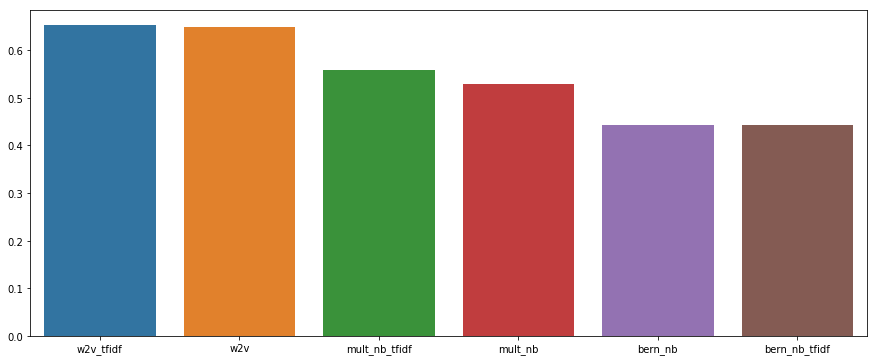

In [65]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])